<a href="https://colab.research.google.com/github/schnelleric/Psychology-of-Human-Social-Networks/blob/master/Prestige_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Modeling a human social network using prestige

The network begins as a grid of size n by m. Each node in the grid is connected to their neighbours above them, below them, and to their left and right.

An algorithm for adding new edges between nodes is then applied to the network. This algorithm is based on observed dynamics in human social learning based on cultural evolutionary theory. Specifically, it mimics how individuals try to connect to prestigious members of their community or network where prestige is defined as eigenvector centrality. However, it is also factors in that physical distance within a network introduces inefficiencies. That is that two individuals who are far apart from one another are less likely to connect as they are less likely to meet.

The algorithm works by first selecting a node, node A, at random within the network. Then every other node is given a probability of also being selected to connect with this node A. Given another node B in the network, the probability b is chosen to connect to A is given as follows:

$p_{b} = v_{b} \cdot e^{-2k_{ab}}$

$v_{b}$ is the eigenvector centrality of node B, which represents B's prestige. $k_{ab}$ is the shortest distance between node A and node B, or the least number of edges that must be crossed to get from A to B. For instance, this means neighbouring nodes have a distance of 1. $e^{-2k}$ is a decay function which then prioritizes nodes closer to A. [PLOT decay function]. 

As a special case if for some node C, $k_{ac} = 1$, then $p_{c} = 0$. This represents the case where C is a neighbour of A, so there already exists an edge between A and C. As a result, C cannot be selected to receive a new edge with A.

These probabilities are then multiplied by $(\sum_{n}{p_{n}})^{-1}$ to normalize the values and ensure that the probabilities add up to 1.

This algorithm repeats until the desired average shortest path length provided is reached.

Given a desired average shortest path of 3.4, the network generated mimics human social networks with a clustering coeffecient between 0.1 and 0.2, depending on the size of the network, and a degree distribution following a powerlaw distribution.

In [0]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import collections
import scipy.stats as stats
import math
import time

The following is a plot of the decay function used, $e^{-2k}$.

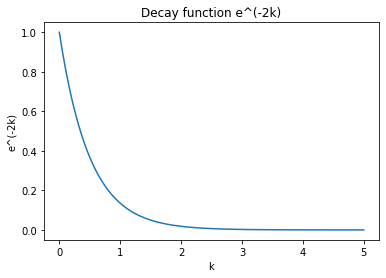

In [2]:
k = np.linspace(0,5,100)
y = []
for val in k:
    y.append(math.exp(-2*val))
plt.plot(k, y)
plt.title("Decay function e^(-2k)")
plt.ylabel("e^(-2k)")
plt.xlabel('k')
plt.show()


In [0]:
def human_social_network_prestige(grid, geodesic):
    """
    Returns a network that mimics human social networks where people try to connect to prestigious individuals 
    within the network. The prestige of a node in the network is its eigenvector centrality. A decay function 
    is also employed, where connections are more likely between two nodes near one another.

    Parameters
    ----------
    grid : (int, int)
        Tuple of grid dimensions. Number of nodes in network is grid[0]*grid[1]
    geodesic : float
        Desired average shortest path length
        This will be treated as an upper bound

    Notes
    -----
    The algorithm works by creating a grid where nodes are connected to their neighbors
    to the North, South, East, and West. The top and bottom of the grid and left and right
    are connected to form a torus, ensuring all nodes have the same number of edges initially.

    At each iteration one node (A) is selected at random to receive a new edge with another node (B).
    A node is more likely to be selected as node B if it has a higher eigenvector centrality and if it is 
    close to node A, with an exponential decay function being employed based on the distance from node A.
    """
    # Set up the graph with connections between neighbors
    G = nx.grid_2d_graph(grid[0], grid[1], True)
    G = nx.convert_node_labels_to_integers(G)
    r = int(round((grid[0] * grid[1]) / 4)) # Frequency of checking whether the desired geodesic is achieved

    while geodesic < nx.average_shortest_path_length(G):
        # Only check for desired geodesic every r iterations as this operation is time consuming
        for i in range(r):
            nodes = list(G.nodes)
            # Select a random node n to receive a new edge
            n = random.choice(nodes)
            odds = []
            centrality = nx.eigenvector_centrality_numpy(G)
            # Make note of all neighbours of n as these cannot be selected to receive an edge with n
            nbrs = [nbr for nbr in G[n]]
            nbrs.append(n)

            for optn in nodes:
                if optn in nbrs:
                    odds.append(0)
                else:
                    dist = nx.shortest_path_length(G, n, optn)
                    # Set the odds of being connected to based on eigenvector centrality of the option and multiply
                    # it by a decay function based on the distance between the nodes
                    w = centrality[optn] * math.exp(-2*(dist))
                    odds.append(w)

            # Select at random a new connection for n from the list of options given their assigned odds
            a = random.choices(nodes, weights=odds, k=1)[0]
            G.add_edge(n, a)

    return G

Make a network.

In [5]:
start = time.time()
G = human_social_network_prestige((30, 30), 3.4)
print(time.time()-start)

320.28553009033203


The following are functions to provide additional information for a given network. One function plots the degree distribution of the network while the other provides the networks geodesic, clustering coefficient, and details relating to the degree distribution's similarity to a power law.

Note that the degree distribution plot uses a logarithmic scale for both axes. The y axis also represents the fraction of the network with a given degree, rather than the total number of nodes with that degree.

In [0]:
def degree_distribution_plot(G):
    """
    Makes a plot for the degree distribution of the inputted graph where the y axis corresponds to the fraction of nodes
    in the graph and the x axis corresponds to the degree of a node. Both axes use a logarithmic scale.

    Parameters
    ----------
    G : Graph
        A graph corresponding to a human social network.

    Notes
    -----
    Values on axes are predetermined and may not be optimal for a given graph.
    """

    # Adapted from https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html
    degrees = [G.degree(n) for n in G.nodes]
    degreeCount = collections.Counter(degrees)
    deg, cnt = zip(*degreeCount.items())
    cnt_frac = []
    for i in range(len(cnt)):
        cnt_frac.append(cnt[i] / G.number_of_nodes())

    plt.scatter(deg, cnt_frac, s=10)

    plt.title("Degree Distribution")
    plt.ylabel("Fraction")
    plt.yscale("log")
    y_ticks = [1, 0.1, 0.01, 0.001, 0.0001]
    plt.yticks(y_ticks, y_ticks)
    plt.xlabel("Degree")
    plt.xscale("log")
    x_ticks = [3, 30, 300]
    plt.xticks(x_ticks, x_ticks)

    plt.show(block=False)

Plot the network's degree distribution.

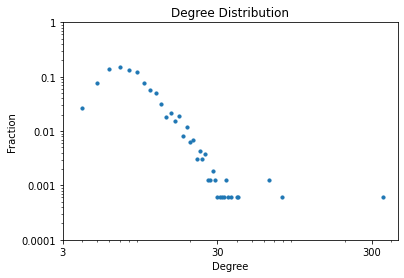

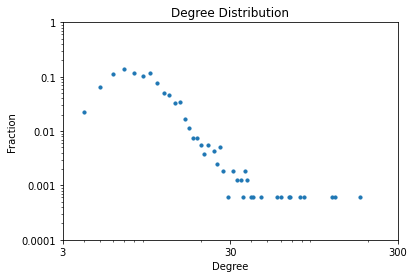

In [0]:
degree_distribution_plot(G)
plt.show()

In [0]:
def graph_statistics(G):
    """
    Prints the characteristic path length (geodesic) of the inputted network G, the clustering coefficient of G,
    and Kolmogorov-Smirnov test results for the similarity of the degree distribution of G with a power law
    distribution.

    Parameters
    ----------
    G : Graph
        A graph corresponding to a human social network.

    Notes
    -----
    KS test is currently not working properly
    """

    curr_geodesic = nx.average_shortest_path_length(G)
    curr_clustering = nx.average_clustering(G)

    degrees = [G.degree(n) for n in G.nodes]

    # Does not seem to properly fit to a powerlaw
    a, l, s = stats.powerlaw.fit(degrees)

    ks, p = stats.kstest(degrees, "powerlaw", args=(a, l, s))


    print("Geodesic: " + str(curr_geodesic) + "; Clustering: " + str(curr_clustering) +
          "; Degree Distribution: alpha = " + str(a) + ", KS = " + str(ks) + ", p = " + str(p))

    return (curr_geodesic, curr_clustering, a, ks, p)

Print statistics relating to the network.

In [0]:
graph_statistics(G)

Geodesic: 3.3761092571993574; Clustering: 0.1423865029454668; Degree Distribution: alpha = 0.27226240786726796, KS = 0.4382177456647753, p = 8.349170850203342e-158


(3.3761092571993574,
 0.1423865029454668,
 0.27226240786726796,
 0.4382177456647753,
 8.349170850203342e-158)